# Footprint the extents of rasters

In [2]:
import rasterio as rio
import rasterio.features
import rasterio.warp
from rasterio.plot import show
from rasterio import Affine, MemoryFile
from rasterio.enums import Resampling

import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import box
import fiona
from fiona.crs import from_epsg
import pprint

import glob
import os
#import s3fs

import sys
sys.path.append('/efs/pmontesa/code/geoscitools')
sys.path.append('/home/pmontesa/code/geoscitools')
import maplib
import footprintlib
from footprintlib import *

# https://gis.stackexchange.com/questions/375577/how-do-i-write-out-a-mixed-geometry-geodataframe-to-a-geopackage
# https://gis.stackexchange.com/questions/187877/how-to-polygonize-raster-to-shapely-polygons

### Set up dictionaries of parameters

Set up an AWSSession

In [15]:
if False:
    import configparser
    config = configparser.ConfigParser()
    config.read('/efs/pmontesa/credentials')
    print(config.sections()[0])
    [print(key) for key in config['boreal_pub']]

    #parse_aws_creds(credentials_fn)[0]

## Build a dictionary of the raster datasets for footprinting

In [49]:
dict_list = [
    # TerraPulse unclipped annual boreal TCC
    {'location':'s3',  #'local' or 's3'
     'data_dir': "s3://terrapulse-pub-data",
     's3_url_prefix': None,
     'data_source': 'terrapulse-pub-data',
     'image_type': 'boreal-tcc-unclipped', 
     'search_tail_string': '/data/**/*y2019_dat.tif', # the year here can vary between 1984-2020; tiles should be exactly the same
     'search_link_string': '',
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'out_footprint_dir': '/efs/projects/forest_height',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': '/efs/pmontesa/credentials'
    },
    {'location':'s3',  #'local' or 's3'
     'data_dir': "s3://terrapulse-pub-data/boreal-forest-data",
     's3_url_prefix': None,
     'data_source': 'terrapulse-pub-data',
     'image_type': 'forest_loss',#'tcc_pvalue',#'tcc_slope', #'tcc_2020', tcc_pvalue, forest_age, forest_loss
     'search_tail_string': '/**/*.tif',
     'search_link_string': '',
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'out_footprint_dir': '/efs/projects/forest_height',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': '/efs/pmontesa/credentials'
    },
    {'location':'local', #'local' or 's3'
     'data_dir': "/efs/projects/data/hls_tiles",
     's3_url_prefix': None,
     'data_source': 'hls_tiles',
     'image_type': 'boreal_tiles_v0003',
     'search_tail_string': '/*.tif',
     'search_link_string': '',
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'out_footprint_dir': '/efs/projects/forest_height/test_out',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': None
    },
    {'location':'local', #'local' or 's3'
     'data_dir': "/att/nobackup/pmontesa/userfs02/data/worldclim/1km/bioclim",
     's3_url_prefix': None,
     'data_source': 'worldclim',
     'image_type': 'wc2.0_30s_bio',
     'search_tail_string': '/wc2.0_bio_30s*.tif',
     'search_link_string': '',
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'out_footprint_dir': '/att/nobackup/pmontesa/userfs02/projects/ilab/boreal_height',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': None
    },   
    {'location':'local', #'local' or 's3'
     'data_dir': "/att/nobackup/pmontesa/userfs02/data",
     's3_url_prefix': None,
     'data_source': 'soil_grids',
     'image_type': 'soil_grids',
     'search_tail_string': '/*.tif',
     'search_link_string': '',
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'out_footprint_dir': '/att/nobackup/pmontesa/userfs02/projects/ilab/boreal_height',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': None
    }, 
    {'location':'local', #'local' or 's3'
     'data_dir': "/att/nobackup/pmontesa/userfs02/data",
     's3_url_prefix': None,
     'data_source': 'awi',
     'image_type': 'MAGT',
     'search_tail_string': '/*PERPROB*.tif',
     'search_link_string': '',
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'out_footprint_dir': '/att/nobackup/pmontesa/userfs02/projects/ilab/boreal_height',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': None
    },    
    {'location': 'local',
     'data_dir': "/adapt/nobackup/projects/ilab/scratch/jli30/data/boreal_forest",
     's3_url_prefix': None,
     'data_source': 'modis_trend',
     'image_type': 'modis_trend',
     'search_tail_string': '/*peak.bias.tif',
     'search_link_string': '',
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'out_footprint_dir': '/att/nobackup/pmontesa/userfs02/projects/ilab/boreal_height',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': None
    },
    {'location': 'local',
     'data_dir': '/adapt/nobackup/people/pmontesa/userfs02/projects/ilab/boreal_height/data',#"/adapt/nobackup/projects/ilab/scratch/jli30/data/boreal_forest",
     's3_url_prefix': None,
     'data_source': 'modis_trend',
     'image_type': 'modis_trend',
     'search_tail_string': '/*peak.bias_reprj-4326.tif',
     'search_link_string': '',
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'out_footprint_dir': '/adapt/nobackup/people/pmontesa/userfs02/projects/ilab/boreal_height/data/modis_trend',#'/att/nobackup/pmontesa/userfs02/projects/ilab/boreal_height',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': None
    },
    {'location': 's3',
     'data_dir': "s3://esa-worldcover",
     's3_url_prefix': "https://esa-worldcover.s3.eu-central-1.amazonaws.com",
     'data_source': 'v100/2020',
     'image_type': 'v100/2020/map',
     'search_tail_string': '/*Map.tif',
     'search_link_string': '',
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'out_footprint_dir': '/efs/projects/forest_height',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': None
    },
    # Eurasia establishment year v2
    {'location': 'local',
     'data_dir': '/adapt/nobackup/people/pmontesa/userfs02/data/standage',
     's3_url_prefix': None,
     'data_source': 'esta_year_n0_m1',
     'image_type': 'boreal_ea/tiles',
     'search_tail_string': '/*esta_year_n0_m1.tif',
     'search_link_string': '',
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'out_footprint_dir': '/adapt/nobackup/people/pmontesa/userfs02/data/standage',#'/att/nobackup/pmontesa/userfs02/projects/ilab/boreal_height',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': None
    },
    # NA establishment year v2
    {'location': 'local',
     'data_dir': '/adapt/nobackup/people/pmontesa/userfs02/data/standage',
     's3_url_prefix': None,
     'data_source': 'esta_year_n0_m1',
     'image_type': 'boreal_na/tiles',
     'search_tail_string': '/*esta_year_n0_m1.tif',
     'search_link_string': '',
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'out_footprint_dir': '/adapt/nobackup/people/pmontesa/userfs02/data/standage',#'/att/nobackup/pmontesa/userfs02/projects/ilab/boreal_height',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': None
    },
    # NA establishment year v2 MMU version
    {'location': 'local',
     'data_dir': '/adapt/nobackup/people/pmontesa/userfs02/data/standage',
     's3_url_prefix': None,
     'data_source': 'esta_year_n0_m1h2',
     'image_type': 'boreal_na/mmu/esta_year_tiles',
     'search_tail_string': '/*esta_year_n0_m1h2.tif',
     'search_link_string': '',
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'out_footprint_dir': '/adapt/nobackup/people/pmontesa/userfs02/data/standage',#'/att/nobackup/pmontesa/userfs02/projects/ilab/boreal_height',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': None
    },
    # 3SL Senegal TOAs: /explore/nobackup/projects/3sl/data/VHR
    {'location': 'local',
     'data_dir': '/explore/nobackup/projects/3sl/data',
     'data_source': '3sl',
     'image_type': 'VHR',
     'search_tail_string': '/**/*M1BS*toa.tif',
     'search_link_string': '',
     'GET_BATCH': True,
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'MANY_CRS': True,
     'out_footprint_dir': '/explore/nobackup/people/pmontesa/userfs02/projects/LULC_Senegal', #'/adapt/nobackup/projects/ilab/projects/srlite/input',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': None
    },
    # AGB ref tiles
    {'location': 'local',
     'data_dir': '/home/pmontesa/code/geoscitools',
     'data_source': 'norway_ref',
     'image_type': 'norway_test_agb_tiles',
     'search_tail_string': '/*.tif',
     'search_link_string': '',
     'GET_BATCH': True,
     'DO_DATAMASK': False,
     'GET_ONLY_DATASETMASK': True,
     'MANY_CRS': True,
     'out_footprint_dir': '/home/pmontesa/code/geoscitools/norway_test_agb_tiles', #'/adapt/nobackup/projects/ilab/projects/srlite/input',
     'footprint_name_SPLIT_CHAR': '_',
     'footprint_name_SPLIT_POS': 0,
     'aws_credential_fn': None
    }
]

In [20]:
if False:
    for d in dict_list:
        print('\n', d['data_source'])

        if d['location'] == 's3':
            import s3fs
            # Use s3fs to access file remote s3 system
            s3 = footprintlib.get_s3_fs_from_creds('/home/pmontesa/credentials_test') # '/efs/pmontesa/credentials'
            print(s3.ls(d['data_dir']))

### Run the footprinting code over an s3 datalist to return and geodataframe and a geopackage **updated** 

https://stackoverflow.com/questions/67812512/rasterio-does-not-exist-in-the-file-system-and-is-not-recognized-as-a-support

In [50]:
######################
# Select a dictionary
d = dict_list[-1]
TEST=False
TEST_SIZE=100
CHUNK=False
CHUNK_SIZE=5000
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]
######################
d

{'location': 'local',
 'data_dir': '/home/pmontesa/code/geoscitools',
 'data_source': 'norway_ref',
 'image_type': 'norway_test_agb_tiles',
 'search_tail_string': '/*.tif',
 'search_link_string': '',
 'GET_BATCH': True,
 'DO_DATAMASK': False,
 'GET_ONLY_DATASETMASK': True,
 'MANY_CRS': True,
 'out_footprint_dir': '/home/pmontesa/code/geoscitools/norway_test_agb_tiles',
 'footprint_name_SPLIT_CHAR': '_',
 'footprint_name_SPLIT_POS': 0,
 'aws_credential_fn': None}

In [53]:
%%time

footprint_gdf_list = list()

# Below - chunk number appended to end
filename = 'footprints_' + d['data_source'].replace('/','_')+'_'+d['image_type'].replace('/','_') #+'.gpkg'

#SEARCH_STR_LIST = ["/", sensor, image_type, ".tif"]
SEARCH_STR_LIST = ["/", d['image_type'], d['search_tail_string']]
keystring = d['search_link_string'].join(SEARCH_STR_LIST)
print(d['data_dir'] + keystring)

# Build raster filename list
if d['location'] == 'local':
    r_fn_list = glob.glob(d['data_dir'] + keystring, recursive=True)
    
if d['location'] == 's3':
    print('on s3...')
    if d['aws_credential_fn'] is None:
        s3 = get_s3_fs_from_creds(anon=True)
    else:
        s3 = get_s3_fs_from_creds(credentials_fn=d['aws_credential_fn'])
    r_fn_list = s3.glob(d['data_dir'] + keystring)
    r_fn_list = ['s3://' + f for f in r_fn_list]

if TEST:
    print(f'Test size: {TEST_SIZE}')
    r_fn_list = r_fn_list[0:TEST_SIZE]
    print(f'Show first 5 rasters in list:\n{r_fn_list[0:5]}')
    filename = 'TEST_' + filename

print(f'{len(r_fn_list)} total inputs from ' + d['data_source'] )    

# Set up a list of raster filename lists to handle chunking if true
if CHUNK:
    print(f'Chunk size: {CHUNK_SIZE}')
    LIST_CHUNKS_r_fn_list = chunks(r_fn_list, CHUNK_SIZE)
else:
    LIST_CHUNKS_r_fn_list = [r_fn_list]

# Loop over chunks
for r_fn_list_idx, r_fn_list in enumerate(LIST_CHUNKS_r_fn_list):
    if CHUNK:
        outprint_fn = os.path.join(d['out_footprint_dir'], filename + f'_chunk{r_fn_list_idx+1:03}'+'.gpkg')
    else:
        outprint_fn = os.path.join(d['out_footprint_dir'], filename.strip('_') + '.gpkg')

    # Get list of geodataframes of individual raster footprints 
    #
    if d['location'] == 'local':
        # Raster files are local
        # Get a list geodataframes of indiv raster footprint geometries (both data and mask)
        f_gdf_lst = [raster_footprint(r_fn, DO_DATAMASK=d['DO_DATAMASK'], GET_ONLY_DATASETMASK=d['GET_ONLY_DATASETMASK'], R_READ_MODE='r') for r_fn in r_fn_list]

    if d['location'] == 's3':
        # Raster files are on s3
        # Get the rio AWS session needed to access the s3 rasters in order to footprint
        if d['aws_credential_fn'] is None:
            if d['s3_url_prefix'] is not None:
                # This doesnt work
                #f_gdf_lst = [raster_footprint(s3.open(r_fn, mode = 'r'), DO_DATAMASK=d['DO_DATAMASK'], GET_ONLY_DATASETMASK=d['GET_ONLY_DATASETMASK'], R_READ_MODE='r') for r_fn in r_fn_list]
                r_fn_list = [f.replace(d['data_dir'], d['s3_url_prefix']) for f in r_fn_list]
            f_gdf_lst = [raster_footprint(r_fn, DO_DATAMASK=d['DO_DATAMASK'], GET_ONLY_DATASETMASK=d['GET_ONLY_DATASETMASK'], R_READ_MODE='r') for r_fn in r_fn_list]
        else:
            aws_session = get_rio_aws_session_from_creds(d['aws_credential_fn'])
            with rio.Env(aws_session):
                # Get a list geodataframes of indiv raster footprint geometries (both data and mask)
                f_gdf_lst = [raster_footprint(r_fn, DO_DATAMASK=d['DO_DATAMASK'], GET_ONLY_DATASETMASK=d['GET_ONLY_DATASETMASK'], R_READ_MODE='r') for r_fn in r_fn_list]

    if len(f_gdf_lst)==0:
        print('\nNothing was footprinted.\n')
    else:
        # Build a footprint database geodataframe from all individual raster footprints
        footprint_gdf = build_footprint_db(f_gdf_lst, TO_GCS=False, WRITE_GPKG=True, OUT_F_NAME=outprint_fn, OUT_LYR_NAME=d['image_type'])

        # depracating this part
        footprint_gdf['footprint_name'] = footprint_gdf['file'].str.split(d['footprint_name_SPLIT_CHAR'], expand=True)[d['footprint_name_SPLIT_POS']]
        footprint_gdf_list.append(footprint_gdf)


/home/pmontesa/code/geoscitools/norway_test_agb_tiles/*.tif
6 total inputs from norway_ref
Building GDF from list...
Wrote out spatial footprints to /home/pmontesa/code/geoscitools/norway_test_agb_tiles/footprints_norway_ref_norway_test_agb_tiles.gpkg
CPU times: user 51.1 ms, sys: 19.4 ms, total: 70.5 ms
Wall time: 167 ms


In [54]:
footprint_gdf['local_path'] = '/projects/shared-buckets/lduncanson/norway_test_data/' + footprint_gdf['file']
footprint_gdf['id'] = footprint_gdf['file'].str.split('_', expand=True)[1].str.strip('*.tif').astype(int)
footprint_gdf = footprint_gdf.to_crs(4326)
footprint_gdf.crs
footprint_gdf.to_file('/home/pmontesa/code/geoscitools/norway_test_agb_tiles/footprints_norway_ref_AGB_tiles.gpkg', driver='GPKG', layer='footprints_norway_ref_AGB_tiles')

In [37]:
print(d['data_dir'] + keystring)
glob.glob('/explore/nobackup/projects/3sl/data/VHR/**/**/*M1BS*toa.tif')

/explore/nobackup/projects/3sl/data/VHR/**/*M1BS*toa.tif


['/explore/nobackup/projects/3sl/data/VHR/CAS/M1BS/WV02_20101031_M1BS_103001000720F800-toa.tif',
 '/explore/nobackup/projects/3sl/data/VHR/CAS/M1BS/WV02_20110317_M1BS_1030010009A95F00-toa.tif',
 '/explore/nobackup/projects/3sl/data/VHR/CAS/M1BS/WV02_20200615_M1BS_10300100A8B6BF00-toa.tif',
 '/explore/nobackup/projects/3sl/data/VHR/CAS/M1BS/WV02_20121218_M1BS_103001001D773D00-toa.tif',
 '/explore/nobackup/projects/3sl/data/VHR/CAS/M1BS/WV02_20140124_M1BS_103001002BC1CB00-toa.tif',
 '/explore/nobackup/projects/3sl/data/VHR/CAS/M1BS/WV02_20151225_M1BS_103001004FC2BD00-toa.tif',
 '/explore/nobackup/projects/3sl/data/VHR/CAS/M1BS/WV02_20141110_M1BS_103001003AA46B00-toa.tif',
 '/explore/nobackup/projects/3sl/data/VHR/CAS/M1BS/WV02_20141129_M1BS_103001003B0A5F00-toa.tif',
 '/explore/nobackup/projects/3sl/data/VHR/CAS/M1BS/WV02_20121014_M1BS_103001001B793900-toa.tif',
 '/explore/nobackup/projects/3sl/data/VHR/CAS/M1BS/WV02_20190127_M1BS_103001008ABC2C00-toa.tif',
 '/explore/nobackup/projects/3

In [26]:
# Concat chunks and write full file
print('Concatenating all chunks into a single gdf and saving...')
footprint_gdf = pd.concat(footprint_gdf_list)

if 'boreal-tcc-unclipped' in d['image_type']:
    print('Overriding CRS...')
    import pyproj
    # This comes from the dataset.profile of one of the raster tiles
    crs_sin = pyproj.crs.CRS.from_wkt('PROJCS["unnamed",GEOGCS["unnamed ellipse",DATUM["unknown",SPHEROID["unnamed",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')
    
    footprint_gdf = footprint_gdf.set_crs(crs_sin, allow_override=True)
    
# Make a 'tile_num' field based on index
footprint_gdf['tile_num'] = footprint_gdf.index

# Make an s3_path field with full filename path
footprint_gdf["s3_path"] = footprint_gdf[['path', 'file']].apply(lambda row: os.path.join(*row), axis=1)

print(f"Saving concatenated footprint to: {os.path.join(d['out_footprint_dir'], filename +'.gpkg')}") 
footprint_gdf.to_file(os.path.join(d['out_footprint_dir'], filename +'.gpkg'), driver='GPKG')                     

Concatenating all chunks into a single gdf and saving...
Saving concatenated footprint to: /adapt/nobackup/people/pmontesa/userfs02/data/standage/footprints_esta_year_n0_m1_boreal_ea_tiles.gpkg


#### Test access to rasters on s3

In [50]:
footprint_gdf["s3_path"] = footprint_gdf[['path', 'file']].apply(lambda row: os.path.join(*row).replace('y2019','y1999'), axis=1)
footprint_gdf.s3_path.to_list()[0]

's3://terrapulse-pub-data/boreal-tcc-unclipped/data/h1000/v084/h1000v084/h1000v084_y1999_dat.tif'

s3://terrapulse-pub-data/boreal-tcc-unclipped/data/h991/v145/h991v145/h991v145_y2009_dat.tif
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 801, 'height': 801, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["unnamed ellipse",DATUM["unknown",SPHEROID["unnamed",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30.0, 0.0, 3768890.6442025825,
       0.0, -30.0, 6527554.677898709), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


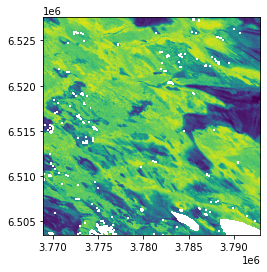

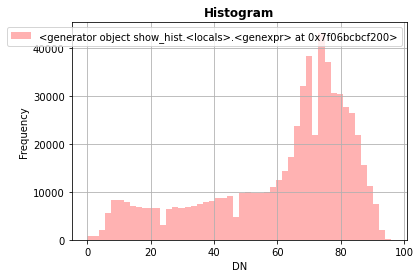

In [48]:
r_fn = r_fn_list[1000].replace('y2019','y2009')
print(r_fn)
with rasterio.Env(AWS_NO_SIGN_REQUEST='YES'):
    with rasterio.open(r_fn, mode='r') as dataset:
        print(dataset.profile)
        from rasterio.plot import show_hist
        import contextily as ctx
        show(dataset)
        
        show_hist(
            dataset, bins=50, lw=0.0, stacked=False, alpha=0.3,
            histtype='stepfilled', title="Histogram")

### Select the footprints gdf

In [41]:
footprint_gdf = footprint_gdf_list[0]
#print(footprint_gdf.path.to_list())
#print(footprint_gdf.to_crs(4326).iloc[1])
#print(footprint_gdf.iloc[1])
#footprint_gdf[footprint_gdf.file=='MCD12Q2.h12v02.peak.bias.tif'].to_crs(4326).geometry.to_json()
#footprint_gdf.crs.to_json()

## Map the footprints

In [ ]:
#maplib.MAP_LAYER_FOLIUM(footprint_gdf.iloc[[3,5]], zoom_start=2)
maplib.MAP_LAYER_FOLIUM(footprint_gdf, LAYER_COL_NAME='file', zoom_start=2, lon_start=0)

### Check terrapulse stand age footprints

In [6]:
f_fn = '/efs/projects/forest_height/footprints_terrapulse-pub-data_forest_age_v2.gpkg'
import fiona
print(fiona.listlayers(f_fn))

f_age_gdf = gpd.read_file(f_fn, layer=fiona.listlayers(f_fn)[0])
maplib.MAP_LAYER_FOLIUM(f_age_gdf, LAYER_COL_NAME='path', zoom_start=2, lon_start=0)

['forest_age']


/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


### Manually check footprint for a single image

In [30]:
r_fn = '/att/nobackup/pmontesa/userfs02/data/MAGT/UiO_PEX_PERPROB_3.0_20171201_2000_2016.tif'
r_fn = '/att/nobackup/pmontesa/userfs02/data/soil_grids/CECSOL_M_sl2_250m_ll.tif'
r_fn = '/att/nobackup/pmontesa/userfs02/data/worldclim/1km/bioclim/wc2.0_30s_bio/wc2.0_bio_30s_01.tif'
footprint_gdf = raster_footprint(r_fn, DO_DATAMASK=d['DO_DATAMASK'], GET_ONLY_DATASETMASK=d['GET_ONLY_DATASETMASK'], R_READ_MODE='r+')
maplib.MAP_LAYER_FOLIUM(footprint_gdf, LAYER_COL_NAME='path', zoom_start=2, lon_start=0)